In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Concatenate, Input, concatenate, Activation
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


In [4]:
# load the files
houselist = glob.glob('HousesDataset/*.jpg')

image_data = []
for fname in houselist:
    image_name = fname.split('/')[1].split('.')[0]
    image_data.append((image_name, Image.open(fname)))
    pass

text_data = pd.read_csv('HousesDataset/HousesInfo.txt', sep=' ',
                        names=["nBeds", "nbaths", "area", "zipcode", "price"])

In [147]:
row, col = 64, 64
X11 = np.zeros((535, row, col, 3)).astype(int)
X12 = np.zeros((535, row, col, 3)).astype(int)
X13 = np.zeros((535, row, col, 3)).astype(int)
X14 = np.zeros((535, row, col, 3)).astype(int)
for name, image in tqdm(image_data):
    index, room = name.split('_')
    if room == "bathroom":
        X11[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "bedroom":
        X12[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "frontal":
        X13[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    else:
        X14[int(index) - 1, :, :] = np.array(image.resize((row, col)))

100%|██████████| 2140/2140 [00:01<00:00, 1089.61it/s]


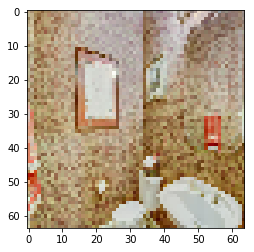

In [148]:
plt.imshow(X11[0])

In [149]:
text_array = np.zeros((535, 5))
for i, text in text_data.iterrows():
    text_array[i] = text.values

In [150]:
X2 = text_array[:, :3]
y = text_array[:, -1]
y_class = np.where(y > 700000, 1, 0)

In [151]:
shuffle = np.arange(len(y))
np.random.shuffle(shuffle)

X11 = X11[shuffle]
X12 = X12[shuffle]
X13 = X13[shuffle]
X14 = X14[shuffle]
X2 = X2[shuffle]
y_class = y_class[shuffle]

split_inedx = 430

x11_train = X11[:split_inedx]
x12_train = X12[:split_inedx]
x13_train = X13[:split_inedx]
x14_train = X14[:split_inedx]
x2_train = X2[:split_inedx]
y_train = y_class[:split_inedx]

x11_test = X11[split_inedx:]
x12_test = X12[split_inedx:]
x13_test = X13[split_inedx:]
x14_test = X14[split_inedx:]
x2_test = X2[split_inedx:]
y_test = y_class[split_inedx:]

x2_min = np.min(x2_train, axis=0)
x2_max = np.max(x2_train, axis=0)
x2_train = (x2_train - x2_min) / (x2_max - x2_min)
x2_test = (x2_test - x2_min) / (x2_max - x2_min)

In [152]:
# cnn model
def visual_model(input_layer):
    conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_layer)
    bat1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bat1)
    flat = Flatten()(pool1)
    x = Dense(8)(flat)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.5)(x)
    
    x = Dense(4)(x)
    x = Activation("relu")(x)
    return x

In [153]:
# visual features (cnn)
visual_input1 = Input(shape=(row, col, 3), name='visual_input1')
visual1 = visual_model(visual_input1)

visual_input2 = Input(shape=(row, col, 3), name='visual_input2')
visual2 = visual_model(visual_input2)

visual_input3 = Input(shape=(row, col, 3), name='visual_input3')
visual3 = visual_model(visual_input3)

visual_input4 = Input(shape=(row, col, 3), name='visual_input4')
visual4 = visual_model(visual_input4)

# textual features (mlp)
textual_input = Input(shape=(3,), name='textual_input')

# merge visual and textual layers
x = keras.layers.concatenate([visual1, visual2, visual3, visual4, textual_input])
# fully connectied
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)

# output
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

In [154]:
model = Model(inputs=[visual_input1, visual_input2, visual_input3, visual_input4, textual_input], outputs=main_output)
model.compile(optimizer="adamax",
              loss={'main_output': 'binary_crossentropy'}, metrics={'main_output': ["accuracy"]})

model.fit([x11_train, x12_train, x13_train, x14_train, x2_train], y_train,
          validation_split=0.2, 
          shuffle=True,
          epochs=20, 
          batch_size=32)

Train on 344 samples, validate on 86 samples
Epoch 1/20
344/344 [==============================] - 13s 36ms/step - loss: 0.7064 - acc: 0.5756 - val_loss: 0.6523 - val_acc: 0.6860
Epoch 2/20
344/344 [==============================] - 3s 8ms/step - loss: 0.7046 - acc: 0.5843 - val_loss: 0.6320 - val_acc: 0.7326
Epoch 3/20
344/344 [==============================] - 3s 8ms/step - loss: 0.6666 - acc: 0.6192 - val_loss: 0.6317 - val_acc: 0.6977
Epoch 4/20
344/344 [==============================] - 3s 8ms/step - loss: 0.6570 - acc: 0.6163 - val_loss: 0.6143 - val_acc: 0.7209
Epoch 5/20
344/344 [==============================] - 3s 8ms/step - loss: 0.6025 - acc: 0.6628 - val_loss: 0.5913 - val_acc: 0.7558
Epoch 6/20
344/344 [==============================] - 3s 8ms/step - loss: 0.6202 - acc: 0.6919 - val_loss: 0.5842 - val_acc: 0.7558
Epoch 7/20
344/344 [==============================] - 3s 8ms/step - loss: 0.5722 - acc: 0.6977 - val_loss: 0.5823 - val_acc: 0.7674
Epoch 8/20
344/344 [=========

In [155]:
y_hat = model.predict([x11_test, x12_test, x13_test, x14_test, x2_test])

In [156]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
print("roc: ", roc_auc_score(y_test, y_hat))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("threshold: ", optimal_threshold)

roc:  0.6892014519056261
threshold:  0.38370174


In [157]:
for y1, y2 in zip(y_class[split_inedx:], np.where(y_hat.ravel() > optimal_threshold, 1, 0)):
    print("y: ",y1, ", y_hat: ", y2)

y:  0 , y_hat:  1
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  1 , y_hat:  1
y:  0 , y_hat:  0
y:  1 , y_hat:  0
y:  1 , y_hat:  1
y:  1 , y_hat:  1
y:  0 , y_hat:  0
y:  1 , y_hat:  0
y:  1 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  1 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  1 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  1 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  1 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  1 , y_hat:  0
y:  0 , y_hat:  1
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  0 , y_hat:  0
y:  1 , y_hat:  1
y:  0 , y_